In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from  tqdm import tqdm_notebook
import tensorflow as tf
import time
from os.path import join

In [2]:
path_train = "/home/phuijse/Work/Data/HiTS/snr_train.tfrecord"
path_val = "/home/phuijse/Work/Data/HiTS/snr_validation.tfrecord"

def decode(serialized_example):
    features = tf.parse_single_example(serialized_example,
                                       features={'image_raw': tf.FixedLenFeature([], tf.string),
                                                 'label': tf.FixedLenFeature([], tf.int64),})
    image = tf.decode_raw(features['image_raw'], tf.float32)
    image = tf.reshape(image, [npix, npix, 4])
    label = tf.cast(features['label'], tf.int32)
    return image, label

def normalize_minmax(image, label):
    image_max = tf.reduce_max(image, axis=[0, 1])
    image_center = tf.reduce_min(image, axis=[0, 1])
    image_scale  = tf.subtract(image_max, image_center)
    image = tf.subtract(image, image_center)
    image = tf.divide(image, tf.maximum(image_scale, tf.constant(1e-8, dtype=tf.float32)))
    return image, label

In [13]:
config = tf.ConfigProto(device_count = {'GPU': 0})

npix = 21
batch_size = 32
n_batches = 10
nepochs = 10

tf.reset_default_graph()

tf_input = tf.placeholder(tf.float32, [None, npix, npix, 4], name='input')
tf_label = tf.placeholder(tf.float32, None, name='target')

with tf.variable_scope('conv_layer1'):
    z = tf.layers.conv2d(inputs=tf_input, filters=32, kernel_size=3, strides=2, 
                         use_bias=True, activation=tf.nn.relu)

with tf.variable_scope('fc_layer1'):
    z = tf.layers.dense(tf.layers.flatten(z), units=128, activation=tf.nn.relu)

with tf.variable_scope('output_layer'):
    y = tf.layers.dense(z, units=1)

with tf.variable_scope('Optimizer'):
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf_label, logits=y)
    loss_op = tf.reduce_mean(cross_entropy)  
    optimizer = tf.train.AdamOptimizer(1e-2)
    train_op = optimizer.minimize(loss_op) 
    init = tf.global_variables_initializer()

with tf.name_scope('summaries'):
    tf.summary.scalar('loss', loss_op)

merged = tf.summary.merge_all()

In [14]:
log_dir = str(time.time())

with tf.Session(config=config) as sess:
    writer_train = tf.summary.FileWriter(join(log_dir, 'train'), sess.graph)
    writer_val = tf.summary.FileWriter(join(log_dir, 'val'), sess.graph)
    
    dataset_train = tf.data.TFRecordDataset(path_train)
    dataset_train = dataset_train.map(decode)
    dataset_train = dataset_train.batch(batch_size)
    #dataset = dataset.shuffle(buffer_size=10000)
    iterator_train = dataset_train.make_initializable_iterator()
    next_element_train = iterator_train.get_next()
    
    dataset_val = tf.data.TFRecordDataset(path_val)
    dataset_val = dataset_val.map(decode)
    dataset_val = dataset_val.batch(batch_size)
    iterator_val = dataset_val.make_one_shot_iterator()
    next_element_val = iterator_val.get_next()
    
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init_op)

    for k in tqdm_notebook(range(nepochs), desc='Train epoch'):
        sess.run(iterator_train.initializer)
        for batch_index in range(n_batches): # Train
            img, lbl = sess.run(next_element_train)
            _, summaries = sess.run([train_op, merged], feed_dict={tf_input: img, tf_label: lbl})
            writer_train.add_summary(summaries)
        
        for batch_index in range(n_batches): # Get projections
            img, lbl = sess.run(next_element_val)
            summaries = sess.run(merged, feed_dict={tf_input: img, tf_label: lbl})
            writer_val.add_summary(summaries)
        
            

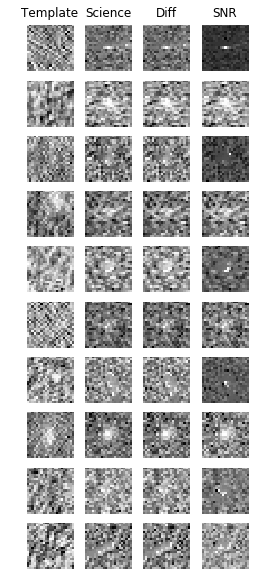

In [15]:
def plot_images(img, lbl, n_images=10):
    fig = plt.figure(figsize=(4, n_images))
    labels = ['Template', 'Science', 'Diff', 'SNR']
    for k1 in range(n_images):
        for k2 in range(4):
            ax = fig.add_subplot(n_images, 4, 4*k1 + k2+1)
            ax.matshow(img[k1,:, :, k2], cmap=plt.cm.Greys_r)
            ax.axis('off')
            if k1 == 0:
                ax.set_title(labels[k2])
plot_images(img, lbl)

**Ejercicio:** Modifique la clase para agregando una segunda capa oculta

**Ejercicio:** Modifique el siguiente código para correr en GPU. 

Por qué no se ve un speed-up considerable en este caso?